In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
eda_filepath = '/media/bayesian-posterior/sdc/sensecode_data/SP1_eda_worn_left.h5'

In [3]:
FS = 4 # E4 sampling rate
FREQ_LIST = [1/(12*60*60), 1/(24*60*60), 1/(7*24*60*60)] # for morlet
FREQ_LIST_COLUMN = ['12 Hours', '24 Hours', '7 Days']

PANDAS_RESAMPLE_RATE = "{:.2f}".format(1/4)+'S' # find missing samples (datetime)
PANDAS_RESAMPLE_RATE

'0.25S'

In [4]:
df_eda = pd.read_hdf(eda_filepath)

In [5]:
# [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(df_eda['eda'].to_numpy(), 1./FS)

In [6]:
def plot_signal(df_eda,
                fs,
                label,
                ylim = None):
    
    plt.figure(figsize=(15, 5))
    
    t = df_eda.index.to_series()
    x = df_eda[label]
    xtick_freq = int(fs*60*60*24*7)
    
    plt.plot(range(len(t)), x, label = label)
    plt.legend(loc=1)
    plt.xticks(range(len(t))[::xtick_freq], t[::xtick_freq], rotation='vertical')

    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Date')
    plt.ylabel('EDA [uS]')
    plt.grid()

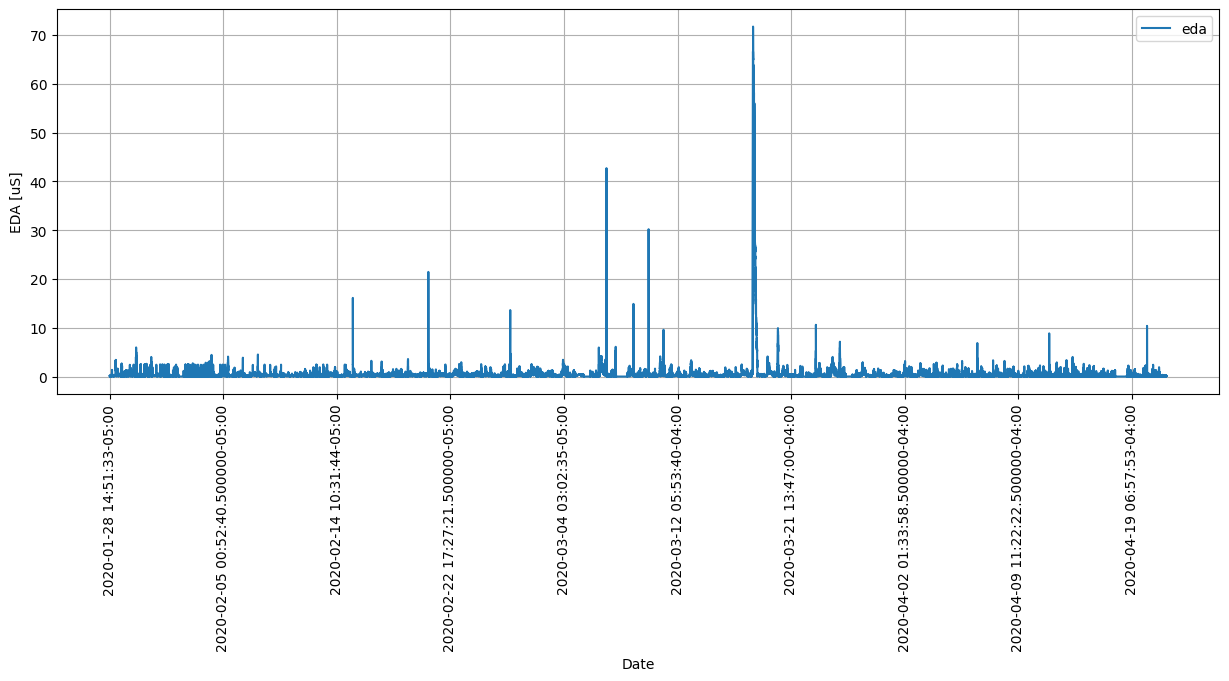

In [7]:
plot_signal(df_eda = df_eda, 
            label = 'eda',
            fs = FS)

In [8]:
#this method implements the method from https://www.nature.com/articles/s41746-018-0074-9
def remove_artifacts(df_eda, 
                     fs, 
                     pandas_resample_rate, 
                     min_eda_value = 0.035, 
                     ratio_good_values = 0.9, 
                     window_size_in_seconds = 5, 
                     max_increased_eda_ratio = 1.2, 
                     max_decreased_eda_ratio = 0.9):

    window_size = int(fs * window_size_in_seconds)
    window_size_half_sec = int(fs * 0.5)
    min_samples_above_threshold_in_each_window = ratio_good_values * window_size
    
    #######remove values below threshold
    # calculate rolling window sum
    # print('Calculating rolling sum')
    # df_eda['eda_above_min_threashold'] = 0
    # df_eda.loc[df_eda['eda'] > min_eda_value, 'eda_above_min_threashold'] = 1
    # df_eda['window_samples_above_threshold'] = df_eda['eda_above_min_threashold'].rolling('5s').sum()
    # # keep only values < max threshold
    # df_eda.loc[df_eda['window_samples_above_threshold'] > min_samples_above_threshold_5sec,'eda_above_min_threashold'] = np.nan
    # df_eda['eda_above_min_threashold'].fillna(method = 'bfill', inplace = True, limit = window_size_5sec )
    
    #######remove values with increasing slope > 10%
    df_eda['eda_increased_from_previous_max'] = df_eda.eda.shift() 
    df_eda['eda_increased_from_previous_max'] = df_eda['eda_increased_from_previous_max'].multiply(max_increased_eda_ratio)
    df_eda['eda_increased_above_threshold'] = df_eda.eda - df_eda.eda_increased_from_previous_max
    df_eda.loc[df_eda['eda_increased_above_threshold'] <= 0, 'eda_increased_above_threshold'] = np.nan
    df_eda['eda_increased_above_threshold'].fillna(method='bfill', inplace=True, limit=window_size_half_sec)
    df_eda['eda_increased_above_threshold'].fillna(method='ffill', inplace=True, limit=window_size_half_sec)
    
    #######remove values with decrease slope > 10%
    df_eda['eda_decreased_from_previous_max'] = df_eda.eda.shift() 
    df_eda['eda_decreased_from_previous_max'] = df_eda['eda_decreased_from_previous_max'].multiply(max_decreased_eda_ratio)
    df_eda['eda_decreased_above_threshold'] = df_eda.eda - df_eda.eda_decreased_from_previous_max
    df_eda.loc[df_eda['eda_decreased_above_threshold'] >= 0, 'eda_decreased_above_threshold'] = np.nan
    df_eda['eda_decreased_above_threshold'].fillna(method='bfill', inplace=True, limit=window_size_half_sec)
    df_eda['eda_decreased_above_threshold'].fillna(method='ffill', inplace=True, limit=window_size_half_sec)
    
    ####keep clean signal####
#     df_eda_clean_signal = df_eda.loc[(df_eda.eda_decreased_above_threshold.isna()) 
#                                      & (df_eda.eda_increased_above_threshold.isna()) 
#                                      & (df_eda.eda_above_min_threashold.isna())]
    
#     df_eda_clean_signal_eda_column = df_eda_clean_signal[['eda']]
#     print('finished slicing EDA column')
#     return df_eda_clean_signal_eda_column

    df_eda = df_eda[(df_eda.eda_decreased_above_threshold.isna()) & (df_eda.eda_increased_above_threshold.isna())]
    df_eda_without_artifacts = df_eda[['eda']].resample(pandas_resample_rate).mean()
    
    return df_eda_without_artifacts

In [9]:
df_eda_without_artifacts = remove_artifacts(df_eda = df_eda, 
                                            fs = FS, 
                                            pandas_resample_rate = PANDAS_RESAMPLE_RATE)

In [10]:
def process_missing_data(df_eda, interpolate_method = 'time'): # pandas interpolate method
    
    df_eda['interpolated_eda'] = df_eda['eda'].interpolate(method=interpolate_method)
    
    upper_quantile = df_eda['interpolated_eda'].quantile(0.99)
    print(upper_quantile)
    df_eda.loc[df_eda['interpolated_eda'] >= upper_quantile, 'interpolated_eda'] = upper_quantile
    
    return df_eda

In [11]:
df_eda_without_artifacts = process_missing_data(df_eda_without_artifacts)

2.161179


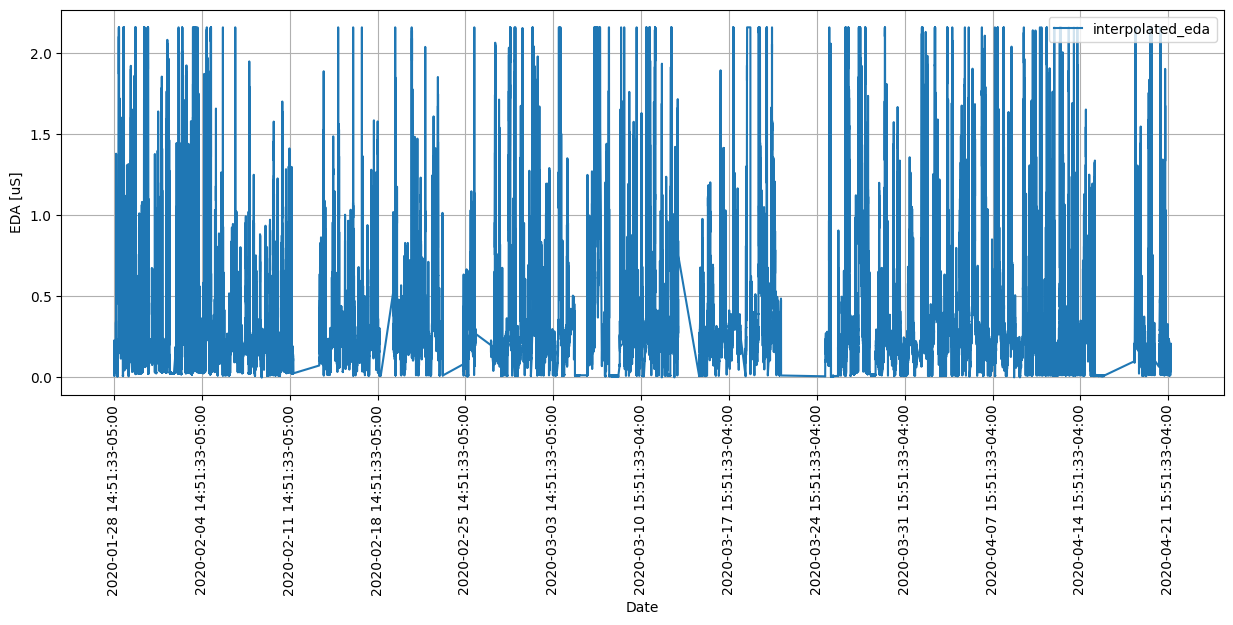

In [12]:
plot_signal(df_eda = df_eda_without_artifacts, 
            label = 'interpolated_eda',
            fs = FS)

In [13]:
def apply_fir(eda: np.ndarray,
              fs,
              cutoff,
              filter_type, # bandpass, lowpass, highpass, bandstop
              transition_band,
              window) -> np.ndarray:
    
    if window == 'hann' or window == 'hamming' or window == 'bartlett':
        M = int(4 * fs / transition_band)
    elif window == 'blackman':
        M = int(6 * fs / transition_band)
    else:
        raise ValueError('Length estimation for this window not implemented')
        
    # print('Using ' + window + ' window for ' + filter_type + ' FIR filter.')
    h = signal.firwin(numtaps = M, 
                      cutoff = cutoff,
                      fs = fs,
                      pass_zero = filter_type,
                      window = window)
    
    eda = np.squeeze(eda)
    return signal.lfilter(h, [1.0], eda) 
    # return signal.filtfilt(h, [1.0], eda) # avoid phase shift of single filter

In [20]:
df_eda_without_artifacts['low_passed_eda'] = apply_fir(eda = df_eda_without_artifacts['interpolated_eda'].to_numpy(), 
                                     fs = FS, 
                                     cutoff = 1, 
                                     transition_band = 0.1,
                                     filter_type = 'lowpass', 
                                     window = 'hamming')

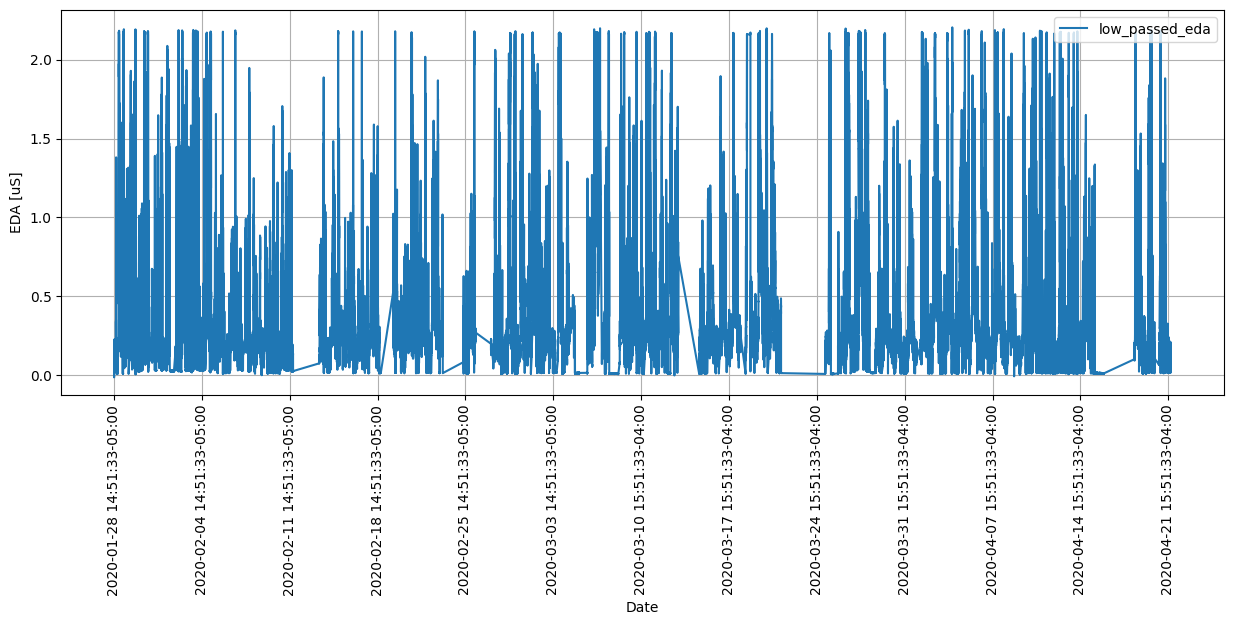

In [21]:
plot_signal(df_eda = df_eda_without_artifacts, 
            label = 'low_passed_eda',
            fs = FS)

In [26]:
def morlet_wavelet(eda: np.ndarray, 
                   fs, 
                   freq_list = [1/(12*60*60), 1/(24*60*60), 1/(7*24*60*60)], 
                   w = 12):
    
    widths = w * fs / (2 * np.asarray(freq_list) * np.pi)
    cwtm = signal.cwt(eda, signal.morlet2, widths, w = w)
    
    return np.abs(cwtm)
    
    # plt.figure(figsize=(15, 3))
    # plt.pcolormesh(range(len(eda)), freq_list, np.abs(cwtm), cmap='viridis', shading='gouraud')
    # plt.show()

In [27]:
cwt_matrix = morlet_wavelet(eda = df_eda_without_artifacts['low_passed_eda'].to_numpy(), fs = FS)

for idx, F in enumerate(FREQ_LIST):
    df_eda_without_artifacts[FREQ_LIST_COLUMN[idx]] = cwt_matrix[idx, :]
    

In [52]:
def plot_morlet(df_eda, 
                freq_list_column = FREQ_LIST_COLUMN, 
                freq_list = FREQ_LIST):

    resampled_df = df_eda_without_artifacts[freq_list_column].resample('W').first()
    cwtm = resampled_df.to_numpy().T # (len(t), len(freq_list))
    
    t = resampled_df.index.to_series()
    xtick_freq = 1
    
    fig, ax = plt.subplots(figsize=(15, 3)) 
    sns.heatmap(cwtm, 
                # center=0, 
                # cmap="vlag", 
                # linewidths=.75, 
                ax=ax)
                # norm=LogNorm(vmin=cwtm.min(), vmax=cwtm.max()))
    
    ax.set_xticks(range(len(t))[::xtick_freq], t[::xtick_freq], rotation='vertical')
    ax.set_yticks(range(len(FREQ_LIST)), FREQ_LIST_COLUMN, rotation='horizontal')


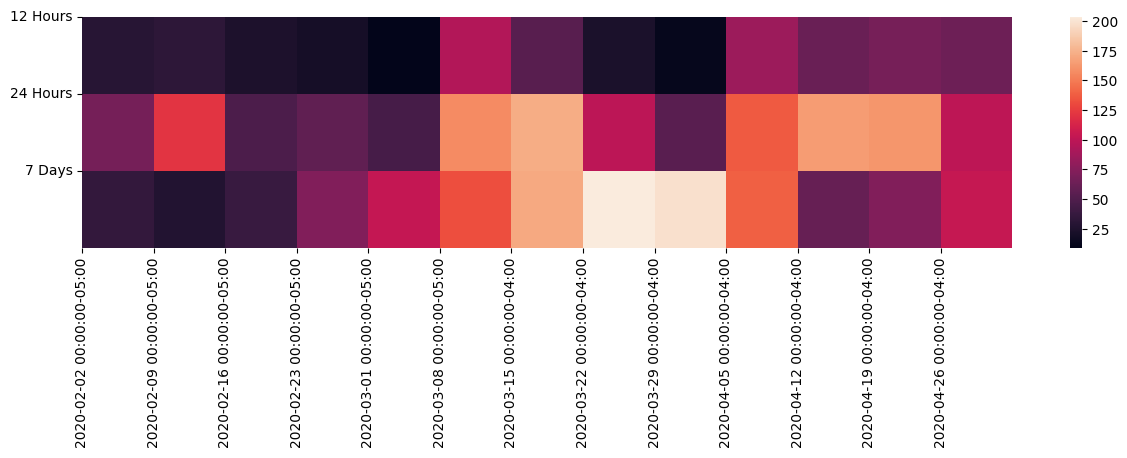

In [53]:
plot_morlet(df_eda = df_eda_without_artifacts, 
            freq_list_column = FREQ_LIST_COLUMN, 
            freq_list = FREQ_LIST)